#### Условие

Прямоугольная металлическая пластина с вырезом используется как теплоотводящий элемент. В угловом вырезе пластины (границы $ \Gamma_2  $ и $ \Gamma_3 $) расположен источник тепла.

Распределение температуры $ T(x,y) $ по площади пластины описывается уравнением Лапласа:

$ \begin{equation} \begin{gathered} \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0 \end{gathered} \end{equation}  $

![](plastine.PNG)

Найти распределение $ T(x, y) $.

_______________________________________________________________________________________________________________

In [1]:
Gamma_1 = Gamma_4 = 28
Gamma_2 = Gamma_3 = 25
Gamma_5 = Gamma_6 = 70

In [2]:
A = 150
B = 75
C = 45

$\textbf{_____________________________________________________________________________________________________________________}$

В уравнении Лапласа заменим производные $ \frac{\partial^2 T}{\partial x^2} $ и $ \frac{\partial^2 T}{\partial y^2} $ формулами численного дифференцирования. 

Получим:

$ \begin{equation} \begin{gathered} \frac{T_{i + 1, j} - 2 \cdot T_{i, j} + T_{i - 1, j}}{\Delta x^2} + \frac{T_{i, j + 1} - 2 \cdot T_{i, j} + T_{i, j - 1}}{\Delta y^2} = 0 \end{gathered}  \end{equation} $

В формуле индекс $ i $ отсчитывается по $ X $, индекс $ j $ - по $ Y $.

#### 1. Квадратные ячейки сетки ($ \Delta x = \Delta y = h \neq 0 $)

При таком предположении формула принимает следующий вид, удобный для итераций:

$ \begin{equation} \begin{gathered} T_{i+1, j} + T_{i - 1, j} + T_{i, j+1} + T_{i, j - 1} - 4 \cdot T_{i, j} = 0 \end{gathered} \end{equation} $

$ \begin{equation} \begin{gathered} T_{i, j} = \frac{1}{4} \cdot (T_{i+1, j} + T_{i - 1, j} + T_{i, j+1} + T_{i, j - 1}) \end{gathered} \end{equation} $

##### 1.0. Задание матрицы начального приближения.

Матрица начального приближения зависит от геометрии пластины, от граничных условий и от шага, который задаётся пользователем.

In [3]:
import numpy as np

In [4]:
def initial(h = 15):
    size_1 = int((B + C) / h + 1)
    size_2 = int(A / h + 1)
    mtx = np.zeros((size_1, size_2))
    mtx[size_1 - 2 : int(B / h) : -1, 0] = Gamma_1
    mtx[int(B / h), : int((A / 2) / h + 1)] = Gamma_2
    mtx[int(B / h - 1) : : -1, int((A / 2) / h)] = Gamma_3
    mtx[0, int((A / 2) / h + 1) : size_2 - 1] = Gamma_4
    mtx[1 : size_1, size_2 - 1] = Gamma_5
    mtx[size_1 - 1, 1 : size_2 - 1] = Gamma_6
    mtx[size_1 - 1, 0] = mtx[0, size_2 - 1] = (Gamma_1 + Gamma_6) / 2
    return mtx

In [5]:
init = initial(h = 1)
print('Матрица начального приближения при шаге h = 15 имеет следующий вид: \n', init)

Матрица начального приближения при шаге h = 15 имеет следующий вид: 
 [[ 0.  0.  0. ... 28. 28. 49.]
 [ 0.  0.  0. ...  0.  0. 70.]
 [ 0.  0.  0. ...  0.  0. 70.]
 ...
 [28.  0.  0. ...  0.  0. 70.]
 [28.  0.  0. ...  0.  0. 70.]
 [49. 70. 70. ... 70. 70. 70.]]


##### 1.1. О критерии окончания методов.

Система уравнений решается итерационными методами. Будем использовать методы Якоби, Зейделя и релаксации.

Метод Якоби:

$ \textbf{x}^{(k + 1)} = \textbf{Bx}^{(k)} + \textbf{c} $

Метод Зейделя:

$ \textbf{x}^{(k + 1)} = \textbf{B}_1 \textbf{x}^{(k + 1)} + \textbf{B}_2 \textbf{x}^{(k)} + \textbf{c} $, где $ \textbf{B}_1 $ и $ \textbf{B}_2 $ - верхняя и нижняя треугольные матрицы $ \textbf{B} $

Метод релаксации:

$ \textbf{x}^{(k + 1)} = (1 - \alpha)\textbf{x}^{(k)} + \alpha (\textbf{B}_1 \textbf{x}^{(k + 1)} + \textbf{B}_2 \textbf{x}^{(k)} + \textbf{c}) $, где $ \alpha \in (0, 2) $

Зададим $ \varepsilon $ - заданная точность.

Критерии окончания для метода Якоби и Зейделя:

$ \begin{equation} \begin{gathered} \| \textbf{x}^{(k + 1)} - \textbf{x}^{(k)} \|_{\infty} \leq \frac{1 - \| \textbf{B} \|_{\infty}}{\| \textbf{B} \|_{\infty}} \varepsilon; \quad \| \textbf{x}^{(k + 1)} - \textbf{x}^{(k)} \|_{\infty} \leq \frac{1 - \| \textbf{B} \|_{\infty}}{\| \textbf{B}_2 \|_{\infty}} \varepsilon \end{gathered} \end{equation} $

На практике данные критерии используются в том случае, если $ \| \textbf{B} \| \leq \frac{1}{2} $. В нашем случае $ \| \textbf{B} \| = 1 $ и вышеприведённые критерии становятся неприменимыми.

Будем использовать более простой критерий окончания 

$ \begin{equation} \begin{gathered}  \| T^{(k + 1)} - T^{(k)} \|_1 \leq \varepsilon  \end{gathered} \end{equation} $

Здесь $ T^{(k + 1)} $ - матрица-сотояние на нынешнем слое (нынешняя итерация), $ T^{(k)} $ - на предыдущем слое.

Поставим элементам, которые необходимо найти, номер, в соответствии с номером уравнения в системе: 

![](sys_1.PNG)

##### 1.2. Метод Якоби (метод простой итерации).

$ \begin{equation} \begin{gathered} T_{i, j}^{(k + 1)} = \frac{1}{4} \cdot (T_{i+1, j}^{(k)} + T_{i - 1, j}^{(k)} + T_{i, j+1}^{(k)} + T_{i, j - 1}^{(k)}) \end{gathered} \end{equation} $

In [6]:
from scipy import linalg

In [7]:
def jacob(eps = 10 ** (-5), h = 15):
    vert_1 = C // h - 1
    vert_2 = B // h
    start_1 = 1
    start_2 = int(0.5 * (A // h) + 1)
    T_= np.copy(init) # T_ - матрица-состояние на предыдущей итерации
    T = np.copy(init)  
    it = 1
    while True:
        x = []
        for i in reversed(range(init.shape[0] - 1 - vert_1, init.shape[0] - 1)):
            for j in range(start_1, init.shape[1] - 1):
                T[i][j] = 0.25 * (T_[i][j - 1] + T_[i + 1][j] + T_[i][j + 1] + T_[i - 1][j])
                
        for i in reversed(range(1, vert_2 + 1)):
            for j in range(start_2, init.shape[1] - 1):
                T[i][j] = 0.25 * (T_[i][j - 1] + T_[i + 1][j] + T_[i][j + 1] + T_[i - 1][j])
                
        if  linalg.norm(np.subtract(T, T_), ord = 1) < eps:
            break
        else:
            it += 1
            T_ = np.copy(T)
            
    print('Количество итераций ', it)
        
    return T

In [8]:
mtx = jacob()
print(mtx)

Количество итераций  111
[[ 0.          0.          0.          0.          0.         70.
  28.         28.         28.         28.         26.5       ]
 [ 0.          0.          0.          0.          0.         70.
  47.63634544 38.02324497 32.78720342 29.01645769 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  54.52213805 43.66943348 36.10911307 30.27862888 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  56.78277615 46.02324167 37.7011911  30.9889471  25.        ]
 [ 0.          0.          0.          0.          0.         70.
  56.58572804 45.93957203 37.68346763 30.97597215 25.        ]
 [70.         70.         70.         70.         70.         70.
  53.62056822 43.46585644 36.11714195 30.23147731 25.        ]
 [28.         45.93044558 51.65868178 53.38232477 53.30457199 51.27606269
  44.43069194 38.18615009 33.08777173 28.83279901 25.        ]
 [28.         34.06310062 37.32195698 38.56604567 38.55990134 37

##### 1.3. Метод Зейделя.

$ \begin{equation} \begin{gathered} T_{i, j}^{(k + 1)} = \frac{1}{4} \cdot (T_{i+1, j}^{(k + 1)} + T_{i - 1, j}^{(k)} + T_{i, j+1}^{(k)} + T_{i, j - 1}^{(k + 1)}) \end{gathered} \end{equation} $

In [7]:
def seidel(eps = 10 ** (-5), h = 15):
    vert_1 = int(C / h - 1)
    vert_2 = int(B / h)
    start_1 = 1
    start_2 = int(0.5 * (A / h) + 1)
    T_= np.copy(init) # T_ - матрица-состояние на предыдущей итерации
    T = np.copy(init)  
    it = 1
    while True:
        x = []
        for i in reversed(range(init.shape[0] - 1 - vert_1, init.shape[0] - 1)):
            for j in range(start_1, init.shape[1] - 1):
                T[i][j] = 0.25 * (T[i][j - 1] + T[i + 1][j] + T_[i][j + 1] + T_[i - 1][j])
                
        for i in reversed(range(1, vert_2 + 1)):
            for j in range(start_2, init.shape[1] - 1):
                T[i][j] = 0.25 * (T[i][j - 1] + T[i + 1][j] + T_[i][j + 1] + T_[i - 1][j])
                
        if  linalg.norm(np.subtract(T, T_), ord = 1) < eps:
            break
        else:
            it += 1
            T_ = np.copy(T)
            
    print('Количество итераций ', it)
        
    return T

In [8]:
import time 

In [9]:
start = time.time()
mtx = seidel(eps = 10 ** (-1), h = 1)
print('Время вычислений:', time.time() - start)
print(mtx)

Количество итераций  3697
Время вычислений: 283.0983798503876
[[ 0.          0.          0.         ... 28.         28.
  49.        ]
 [ 0.          0.          0.         ... 40.6893742  48.99539566
  70.        ]
 [ 0.          0.          0.         ... 48.98158263 57.29220843
  70.        ]
 ...
 [28.         40.67252861 48.94791034 ... 69.95534483 69.97767383
  70.        ]
 [28.         48.9869774  57.27538133 ... 69.97766796 69.98883469
  70.        ]
 [49.         70.         70.         ... 70.         70.
  70.        ]]


In [10]:
init = initial(h = 0.5)
print(init)

[[ 0.   0.   0.  ... 28.  28.  26.5]
 [ 0.   0.   0.  ...  0.   0.  25. ]
 [ 0.   0.   0.  ...  0.   0.  25. ]
 ...
 [28.   0.   0.  ...  0.   0.  25. ]
 [28.   0.   0.  ...  0.   0.  25. ]
 [26.5 25.  25.  ... 25.  25.  25. ]]


In [11]:
start = time.time()
mtx1 = seidel(eps = 10 ** (-1), h = 0.5)
print('Время вычислений:', time.time() - start)
print(mtx1)

Количество итераций  11610
Время вычислений: 2429.8928418159485
[[ 0.          0.          0.         ... 28.         28.
  26.5       ]
 [ 0.          0.          0.         ... 27.09727229 26.50215664
  25.        ]
 [ 0.          0.          0.         ... 26.50862654 25.91135426
  25.        ]
 ...
 [28.         27.1094411  26.53295569 ... 25.00609662 25.00304803
  25.        ]
 [28.         26.5082389  25.92351455 ... 25.00304821 25.00152397
  25.        ]
 [26.5        25.         25.         ... 25.         25.
  25.        ]]


In [12]:
mtx1.shape

(241, 301)

In [13]:
mtx.shape

(121, 151)

In [19]:
mtx2 = mtx1[::2, ::2]

In [20]:
mtx2.shape

(121, 151)

##### 1.4. Метод релаксации.

$ 
\begin{multline} 
\begin{aligned} 
&\widetilde{T}_{i, j}^{(k + 1)} = \frac{1}{4} \cdot (T_{i+1, j}^{(k + 1)} + T_{i - 1, j}^{(k)} + T_{i, j+1}^{(k)} + T_{i, j - 1}^{(k + 1)}) \\
&T_{i, j}^{(k + 1)} = (1 - \alpha) \cdot T_{i, j}^{(k)} + \alpha \cdot \widetilde{T}_{i, j}^{(k + 1)}
\end{aligned} 
\end{multline} 
$

Здесь $ \alpha \in (0, 2) $ - параметр релаксации. При $ \alpha = 1 $ - метод Зейделя.

In [11]:
def relax(alp, eps = 10 ** (-5), h = 15):
    vert_1 = C // h - 1
    vert_2 = B // h
    start_1 = 1
    start_2 = int(0.5 * (A // h) + 1)
    T_= np.copy(init) # T_ - матрица-состояние на предыдущей итерации
    T = np.copy(init)  
    it = 1
    while True:
        x = []
        for i in reversed(range(init.shape[0] - 1 - vert_1, init.shape[0] - 1)):
            for j in range(start_1, init.shape[1] - 1):
                T[i][j] = (1 - alp) * T_[i][j] + alp * 0.25 * (T[i][j - 1] + T[i + 1][j] + T_[i][j + 1] + T_[i - 1][j])
                
        for i in reversed(range(1, vert_2 + 1)):
            for j in range(start_2, init.shape[1] - 1):
                T[i][j] = (1 - alp) * T_[i][j] + alp * 0.25 * (T[i][j - 1] + T[i + 1][j] + T_[i][j + 1] + T_[i - 1][j])
                
        if  linalg.norm(np.subtract(T, T_), ord = 1) < eps:
            break
        else:
            it += 1
            T_ = np.copy(T)
            
    print('Количество итераций при параметре релаксации ', format(alp, '.3f'), ' - ', it)
        
    return T

In [12]:
for i in range(1, 20):
    relax(alp = i * 0.1)

Количество итераций при параметре релаксации  0.100  -  949
Количество итераций при параметре релаксации  0.200  -  476
Количество итераций при параметре релаксации  0.300  -  310
Количество итераций при параметре релаксации  0.400  -  224
Количество итераций при параметре релаксации  0.500  -  171
Количество итераций при параметре релаксации  0.600  -  135
Количество итераций при параметре релаксации  0.700  -  109
Количество итераций при параметре релаксации  0.800  -  88
Количество итераций при параметре релаксации  0.900  -  72
Количество итераций при параметре релаксации  1.000  -  59
Количество итераций при параметре релаксации  1.100  -  47
Количество итераций при параметре релаксации  1.200  -  37
Количество итераций при параметре релаксации  1.300  -  27
Количество итераций при параметре релаксации  1.400  -  24
Количество итераций при параметре релаксации  1.500  -  28
Количество итераций при параметре релаксации  1.600  -  35
Количество итераций при параметре релаксации  1.7

In [13]:
for i in range(21):
    relax(alp = 1.3 + i * 0.01)

Количество итераций при параметре релаксации  1.300  -  27
Количество итераций при параметре релаксации  1.310  -  26
Количество итераций при параметре релаксации  1.320  -  24
Количество итераций при параметре релаксации  1.330  -  23
Количество итераций при параметре релаксации  1.340  -  21
Количество итераций при параметре релаксации  1.350  -  21
Количество итераций при параметре релаксации  1.360  -  22
Количество итераций при параметре релаксации  1.370  -  22
Количество итераций при параметре релаксации  1.380  -  23
Количество итераций при параметре релаксации  1.390  -  23
Количество итераций при параметре релаксации  1.400  -  24
Количество итераций при параметре релаксации  1.410  -  24
Количество итераций при параметре релаксации  1.420  -  24
Количество итераций при параметре релаксации  1.430  -  25
Количество итераций при параметре релаксации  1.440  -  25
Количество итераций при параметре релаксации  1.450  -  26
Количество итераций при параметре релаксации  1.460  -  

In [14]:
for i in range(51):
    relax(alp = 1.33 + i * 0.001)

Количество итераций при параметре релаксации  1.330  -  23
Количество итераций при параметре релаксации  1.331  -  23
Количество итераций при параметре релаксации  1.332  -  23
Количество итераций при параметре релаксации  1.333  -  22
Количество итераций при параметре релаксации  1.334  -  22
Количество итераций при параметре релаксации  1.335  -  22
Количество итераций при параметре релаксации  1.336  -  22
Количество итераций при параметре релаксации  1.337  -  22
Количество итераций при параметре релаксации  1.338  -  22
Количество итераций при параметре релаксации  1.339  -  21
Количество итераций при параметре релаксации  1.340  -  21
Количество итераций при параметре релаксации  1.341  -  21
Количество итераций при параметре релаксации  1.342  -  21
Количество итераций при параметре релаксации  1.343  -  21
Количество итераций при параметре релаксации  1.344  -  21
Количество итераций при параметре релаксации  1.345  -  21
Количество итераций при параметре релаксации  1.346  -  

##### 1.5. Тепловая карта.

In [29]:
init = initial(h = 5)
mtx = seidel(h = 5)
print(mtx)

Количество итераций  507
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         70.         28.         28.
  28.         28.         28.         28.         28.         28.
  28.         28.         28.         28.         28.         28.
  26.5       ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         70.         48.84837567 40.39611591
  36.34240903 34.05704721 32.59311114 31.56115135 30.7790724  30.15085049
  29.61928238 29.14467382 28.69219486 28.21850653 27.64417757 26.77175654
  25.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         70.         56.9973868  48.39367898
  42.91647304 39.29266873 36.75424609 34.87242191 33.40

In [11]:
from matplotlib import pyplot as plt

<IPython.core.display.Javascript object>


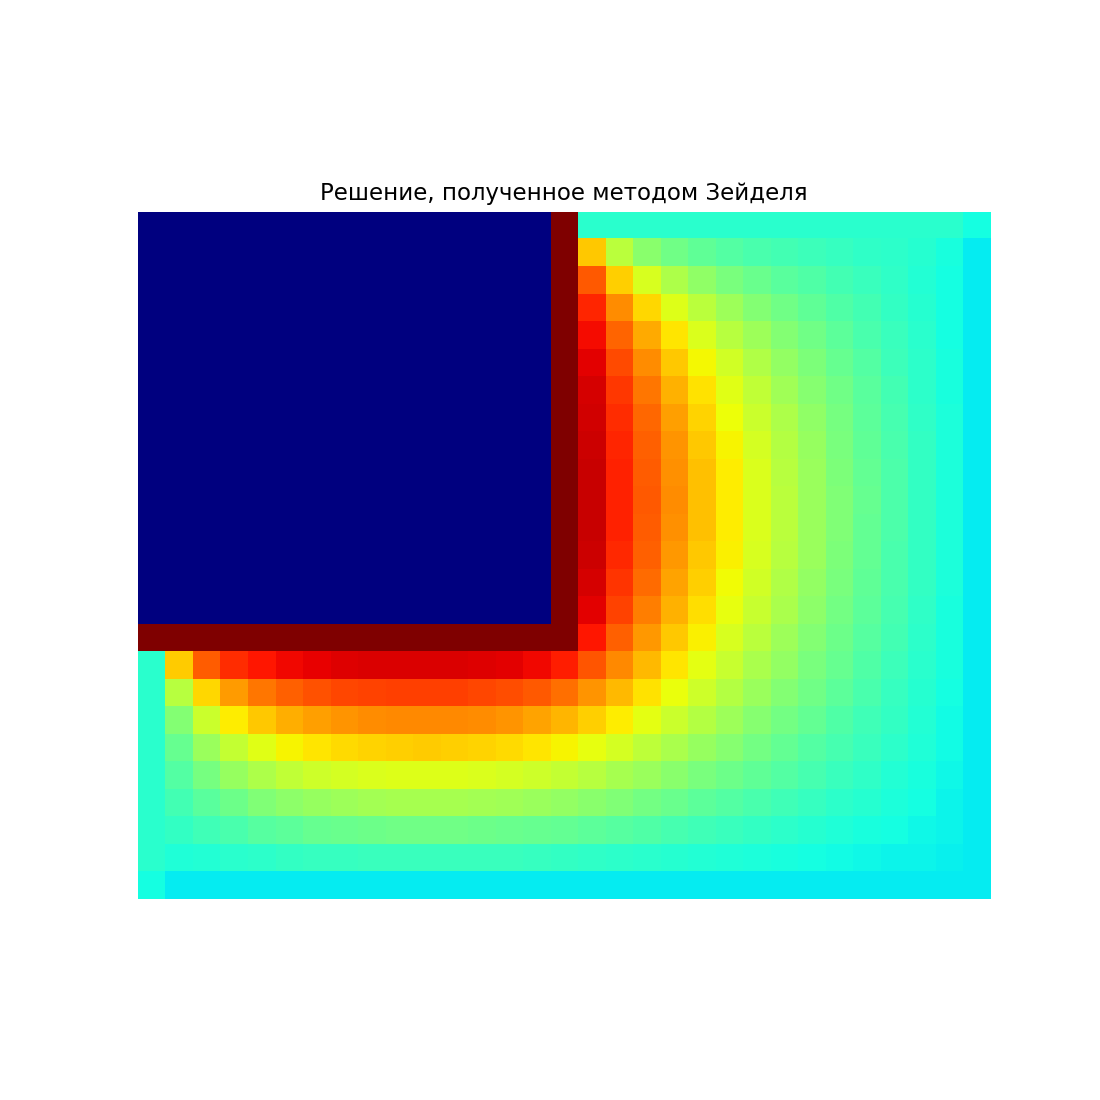

In [31]:
plt.figure(figsize = (8, 8))
plt.title('Решение, полученное методом Зейделя')
plt.imshow(mtx, cmap = 'jet', interpolation = 'nearest')
plt.axis('off')
plt.show()

In [10]:
import seaborn as sns

<AxesSubplot:>

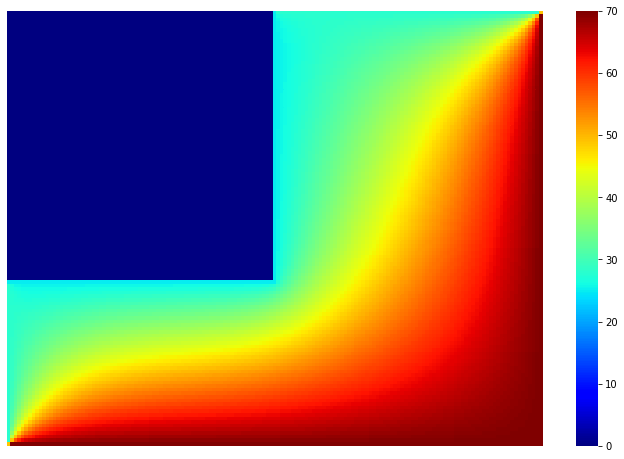

In [12]:
plt.figure(figsize = (12, 8))
sns.heatmap(mtx, cmap = 'jet', xticklabels = False, yticklabels = False)

<AxesSubplot:>

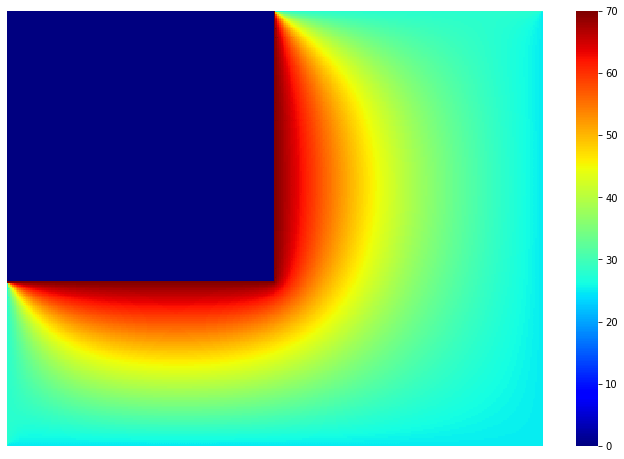

In [16]:
plt.figure(figsize = (12, 8))
sns.heatmap(mtx1, cmap = 'jet', xticklabels = False, yticklabels = False)

##### 1.6. Трёхмерный график решения.

In [13]:
def f(x, y):
    return mtx[x, y]

In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


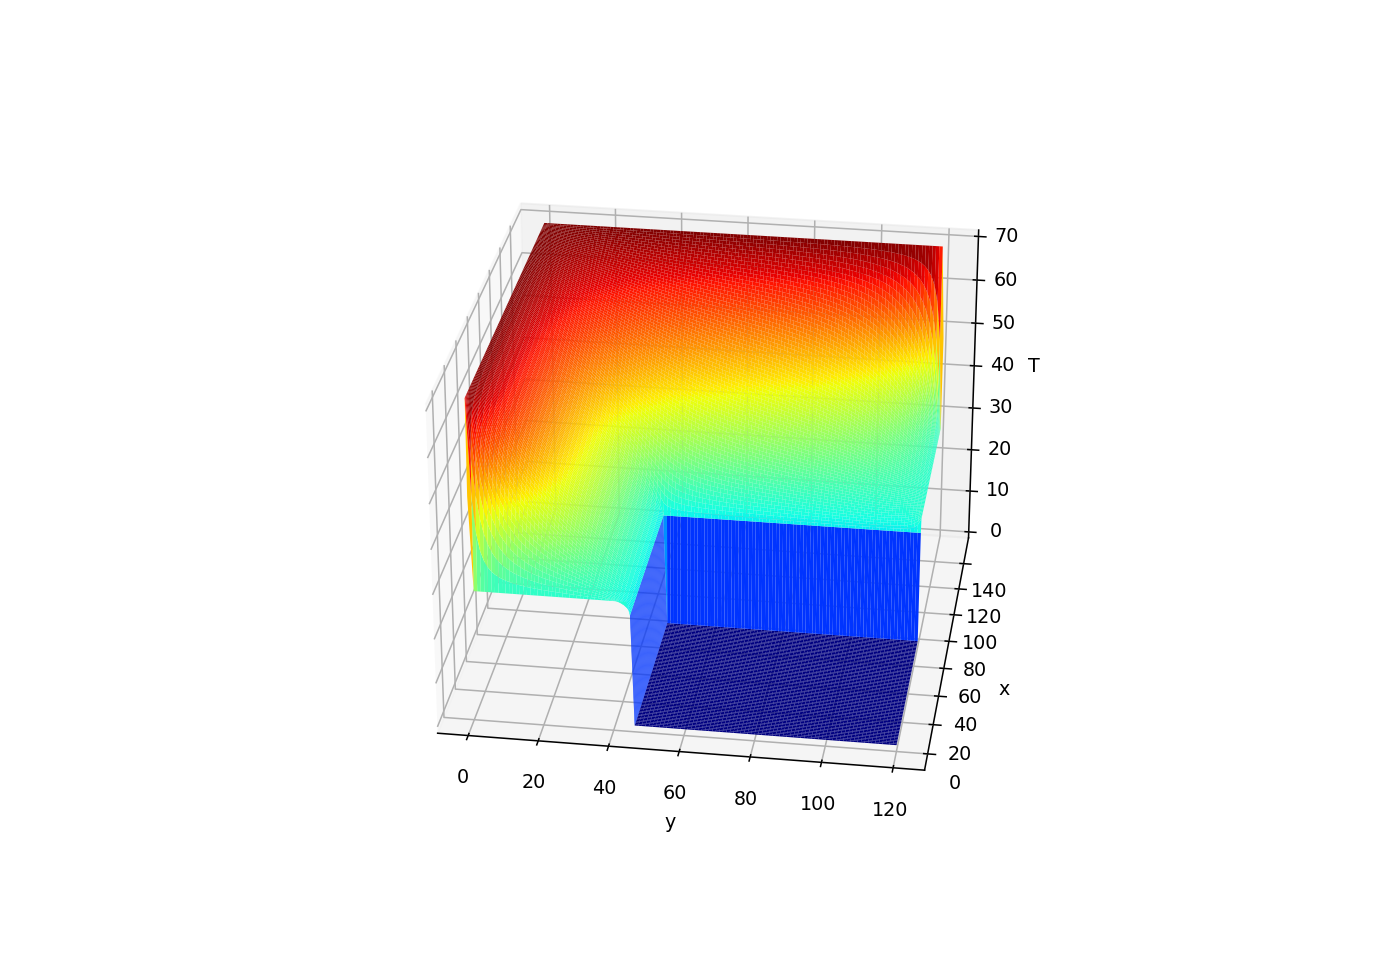

In [18]:
fig = plt.figure(figsize=(10, 7))
ax_3d = fig.add_subplot(projection='3d')

x = np.arange(0, init.shape[0])
y = np.arange(0, init.shape[1])

x, y = np.meshgrid(x, y)

ax_3d.plot_surface(np.flip(x), y, f(x, y), rstride = 1, cstride = 1, cmap = 'jet', color = 'y')

ax_3d.set_xlabel('y')
ax_3d.set_ylabel('x')
ax_3d.set_zlabel('T')

plt.show()

##### 1.7. Графики для шага h = 1.

In [23]:
init = initial(h = 1)
mtx = seidel(h = 1, eps = 10 ** (-2))
print(mtx)

Количество итераций  5463
[[ 0.          0.          0.         ... 28.         28.
  26.5       ]
 [ 0.          0.          0.         ... 27.11437798 26.5107038
  25.        ]
 [ 0.          0.          0.         ... 26.54281515 25.92843721
  25.        ]
 ...
 [28.         27.15926203 26.63244458 ... 25.03412521 25.01705889
  25.        ]
 [28.         26.53311132 25.9731833  ... 25.01706602 25.00853115
  25.        ]
 [26.5        25.         25.         ... 25.         25.
  25.        ]]


<IPython.core.display.Javascript object>


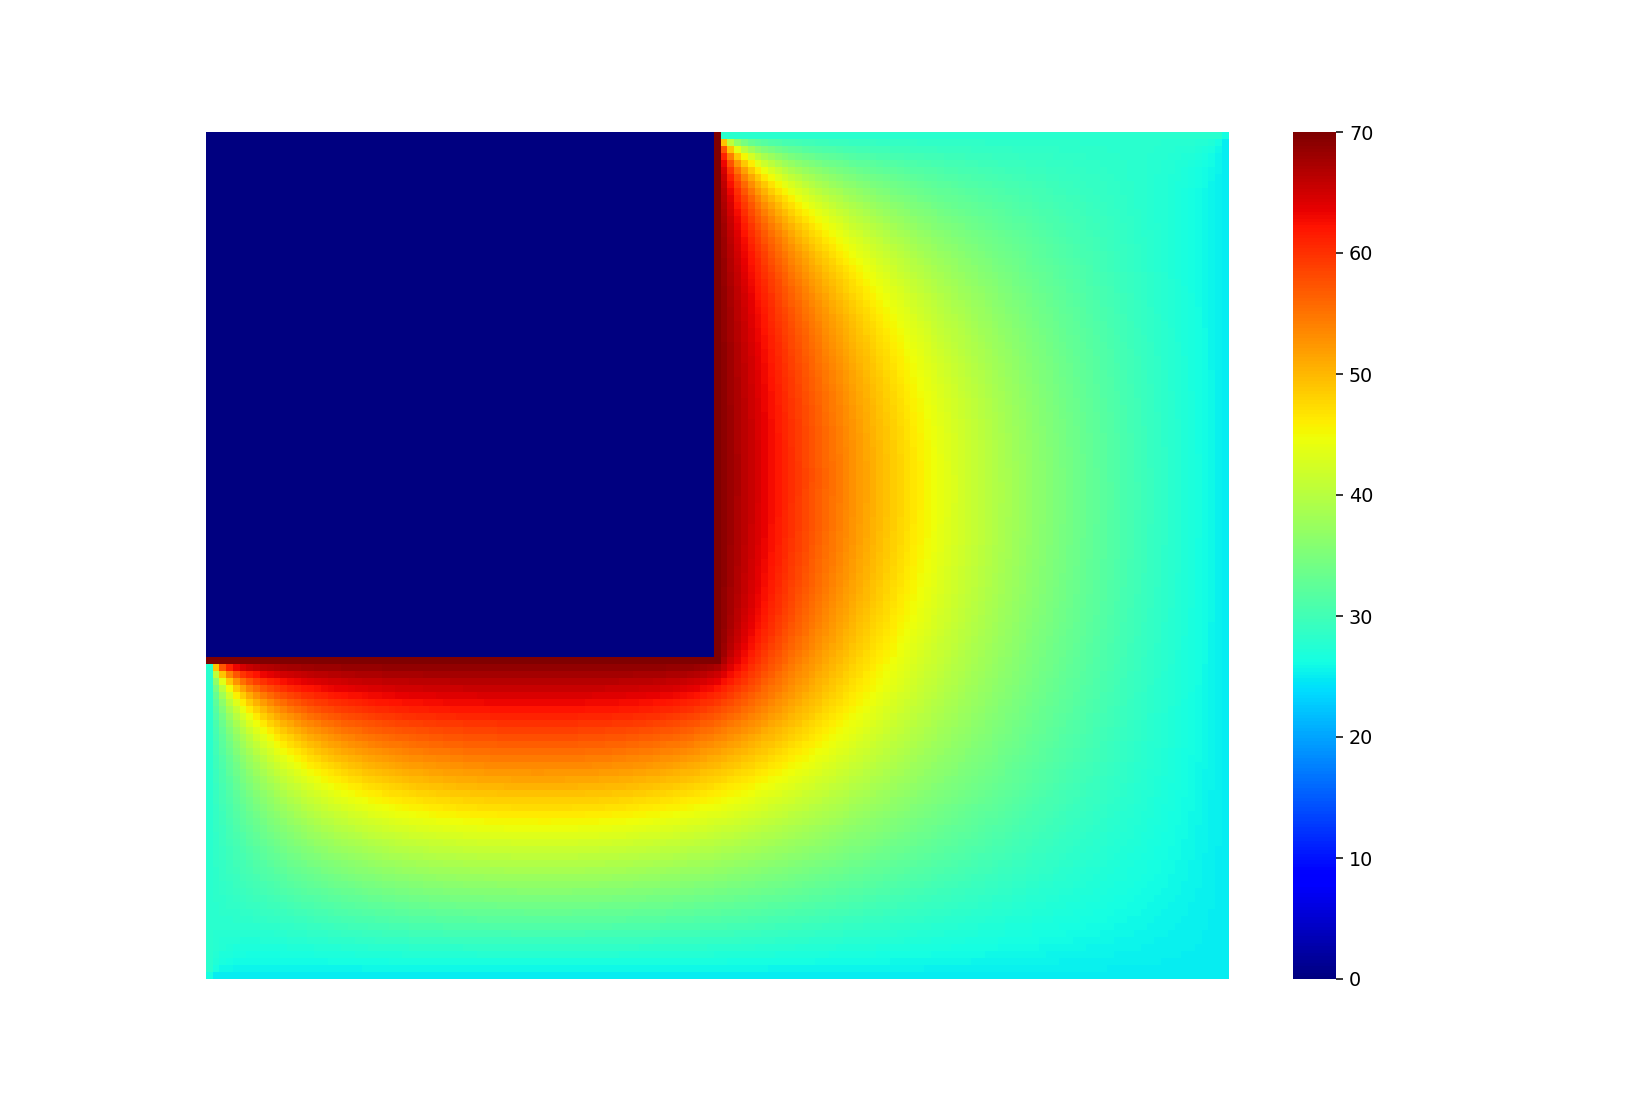

<AxesSubplot:>

In [26]:
plt.figure(figsize = (12, 8))
sns.heatmap(mtx, cmap = 'jet', xticklabels = False, yticklabels = False)

<IPython.core.display.Javascript object>


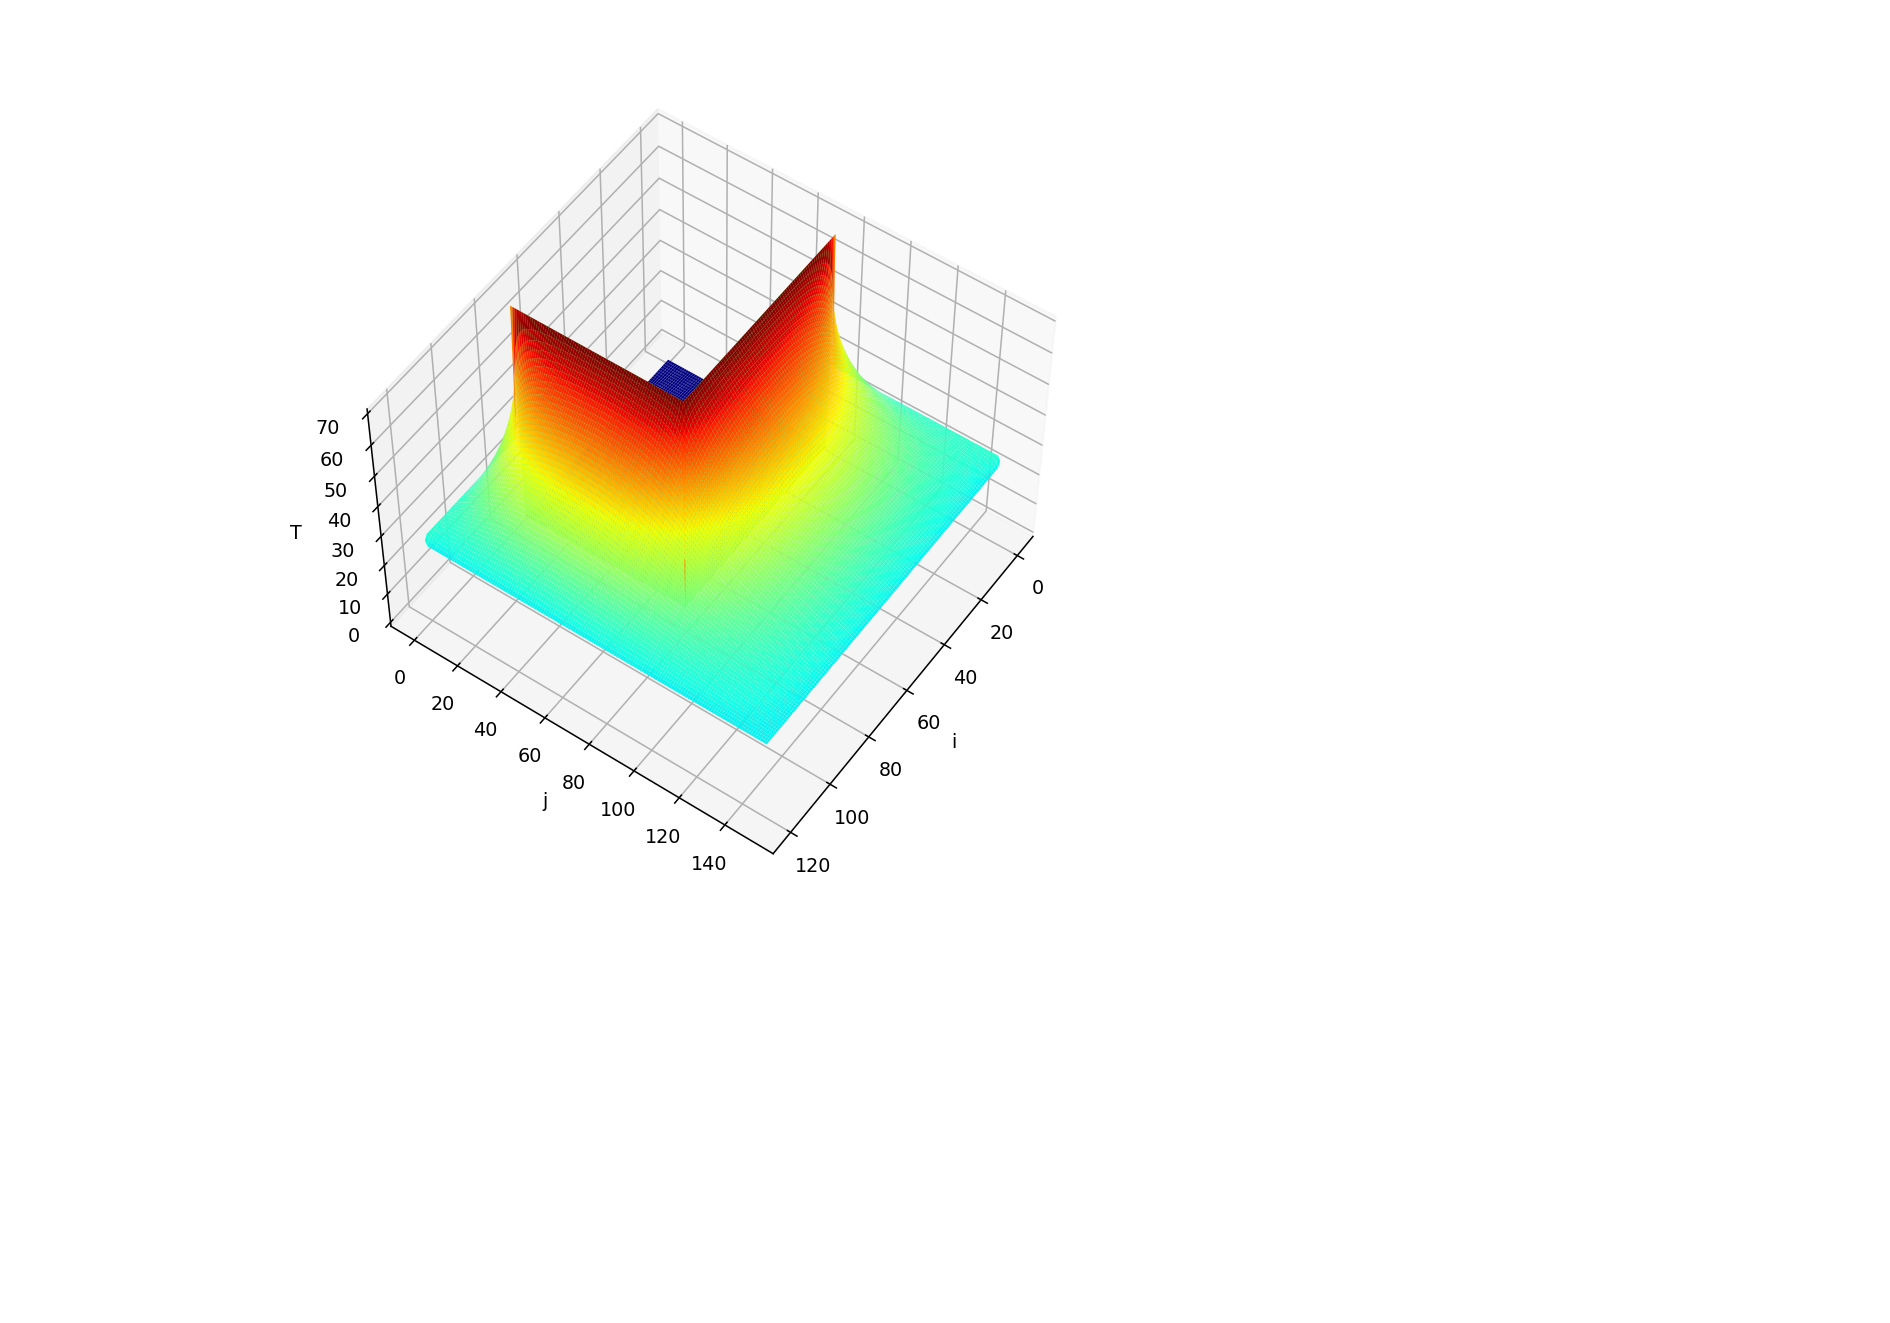

In [27]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 7))
ax_3d = fig.add_subplot(projection='3d')

x = np.arange(0, init.shape[0])
y = np.arange(0, init.shape[1])

x, y = np.meshgrid(x, y)

ax_3d.plot_surface(x, y, f(x, y), rstride = 1, cstride = 1, cmap = 'jet', color = 'y')

ax_3d.set_xlabel('i')
ax_3d.set_ylabel('j')
ax_3d.set_zlabel('T')

plt.show()

##### 2. Общий случай ($ \Delta x \neq \Delta y $) 

При таком предположении формула принимает следующий вид, удобный для итераций:

$
\begin{multline}
\begin{aligned}
&\frac{T_{i - 1, j} - 2T_{i, j} + T_{i + 1, j}}{\Delta x^2} + \frac{T_{i, j - 1} - 2T_{i, j} + T_{i, j + 1}}{\Delta y^2} = 0 \\
&T_{i, j} = C_1 \cdot ( T_{i, j - 1} + T_{i, j + 1} ) + C_2 \cdot ( T_{i - 1, j} + T_{i + 1, j} ) \\
&C_1 = \frac{\Delta x ^ 2}{2 \cdot (\Delta x ^ 2 + \Delta y ^ 2)} \\
&C_2 = \frac{\Delta y ^ 2}{2 \cdot (\Delta x ^ 2 + \Delta y ^ 2)}
\end{aligned}
\end{multline}
$

##### 2.0. Задание матрицы начального приближения.

In [48]:
def initial(h_1 = 15, h_2 = 5):
    size_1 = (B + C) // h_2 + 1
    size_2 = A // h_1 + 1
    mtx = np.zeros((size_1, size_2))
    mtx[size_1 - 2 : B // h_2 : -1, 0] = Gamma_1
    mtx[B // h_2, : (A // 2) // h_1 + 1] = Gamma_2
    mtx[B // h_2 - 1 : : -1, (A // 2) // h_1] = Gamma_3
    mtx[0, (A // 2) // h_1 + 1 : size_2 - 1] = Gamma_4
    mtx[1 : size_1, size_2 - 1] = Gamma_5
    mtx[size_1 - 1, 1 : size_2 - 1] = Gamma_6
    mtx[size_1 - 1, 0] = mtx[0, size_2 - 1] = (Gamma_1 + Gamma_6) / 2
    return mtx

In [49]:
init = initial()
print('Матрица начального приближения имеет следующий вид: \n', init)

Матрица начального приближения имеет следующий вид: 
 [[ 0.   0.   0.   0.   0.  70.  28.  28.  28.  28.  26.5]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [ 0.   0.   0.   0.   0.  70.   0.   0.   0.   0.  25. ]
 [70.  70.  70.  70.  70.  70.   0.   0.   0.   0.  25. ]
 [28.   0.   0.   

##### 2.1. Метод Якоби.

$
\begin{equation}
\begin{gathered}
T_{i, j}^{(k + 1)} = C_1 \cdot ( T_{i, j - 1}^{(k)} + T_{i, j + 1}^{(k)} ) + C_2 \cdot ( T_{i - 1, j}^{(k)} + T_{i + 1, j}^{(k)} )
\end{gathered}
\end{equation}
$

In [50]:
def jacob(eps = 10 ** (-5), h_1 = 15, h_2 = 5):
    vert_1 = C // h_2 - 1
    vert_2 = B // h_2
    start_1 = 1
    start_2 = int(0.5 * (A // h_1) + 1)
    T_= np.copy(init) # T_ - матрица-состояние на предыдущей итерации
    T = np.copy(init)
    C_1 = h_1 ** 2 / (2 * (h_1 ** 2 + h_2 ** 2))
    C_2 = h_2 ** 2 / (2 * (h_1 ** 2 + h_2 ** 2))
    it = 1
    while True:
        x = []
        for i in reversed(range(init.shape[0] - 1 - vert_1, init.shape[0] - 1)):
            for j in range(start_1, init.shape[1] - 1):
                T[i][j] = C_1 * (T_[i][j - 1] + T_[i][j + 1]) + C_2 * (T_[i + 1][j]  + T_[i - 1][j])
                
        for i in reversed(range(1, vert_2 + 1)):
            for j in range(start_2, init.shape[1] - 1):
                T[i][j] = C_1 * (T_[i][j - 1] + T_[i][j + 1]) + C_2 * (T_[i + 1][j]  + T_[i - 1][j])
                
        if  linalg.norm(np.subtract(T, T_), ord = 1) < eps:
            break
        else:
            it += 1
            T_ = np.copy(T)
            
    print('Количество итераций ', it)
        
    return T

In [51]:
mtx = jacob()
print(mtx)

Количество итераций  276
[[ 0.          0.          0.          0.          0.         70.
  28.         28.         28.         28.         26.5       ]
 [ 0.          0.          0.          0.          0.         70.
  57.22994504 47.3531318  39.20557802 31.96939673 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  60.42071453 51.14292852 42.20880371 33.53773231 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  60.89798895 51.83977439 42.84454877 33.90601607 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  60.98109496 51.96971974 42.97005752 33.98165024 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  60.99643252 51.99424816 42.99427183 33.99647107 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  60.99932199 51.99890434 42.998906   33.99932467 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  60.9

##### 2.2. Метод Зейделя.

$
\begin{equation}
\begin{gathered}
T_{i, j}^{(k + 1)} = C_1 \cdot ( T_{i, j - 1}^{(k + 1)} + T_{i, j + 1}^{(k)} ) + C_2 \cdot ( T_{i - 1, j}^{(k)} + T_{i + 1, j}^{(k + 1)} )
\end{gathered}
\end{equation}
$

In [52]:
def seidel(eps = 10 ** (-5), h_1 = 15, h_2 = 5):
    vert_1 = C // h_2 - 1
    vert_2 = B // h_2
    start_1 = 1
    start_2 = int(0.5 * (A // h_1) + 1)
    T_= np.copy(init) # T_ - матрица-состояние на предыдущей итерации
    T = np.copy(init)
    C_1 = h_1 ** 2 / (2 * (h_1 ** 2 + h_2 ** 2))
    C_2 = h_2 ** 2 / (2 * (h_1 ** 2 + h_2 ** 2))
    it = 1
    while True:
        x = []
        for i in reversed(range(init.shape[0] - 1 - vert_1, init.shape[0] - 1)):
            for j in range(start_1, init.shape[1] - 1):
                T[i][j] = C_1 * (T[i][j - 1] + T_[i][j + 1]) + C_2 * (T[i + 1][j]  + T_[i - 1][j])
                
        for i in reversed(range(1, vert_2 + 1)):
            for j in range(start_2, init.shape[1] - 1):
                T[i][j] = C_1 * (T[i][j - 1] + T_[i][j + 1]) + C_2 * (T[i + 1][j]  + T_[i - 1][j])
                
        if  linalg.norm(np.subtract(T, T_), ord = 1) < eps:
            break
        else:
            it += 1
            T_ = np.copy(T)
            
    print('Количество итераций ', it)
        
    return T

In [53]:
mtx = seidel()
print(mtx)

Количество итераций  146
[[ 0.          0.          0.          0.          0.         70.
  28.         28.         28.         28.         26.5       ]
 [ 0.          0.          0.          0.          0.         70.
  57.22994504 47.3531318  39.20557802 31.96939673 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  60.42071453 51.14292852 42.20880371 33.53773231 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  60.89798895 51.83977439 42.84454877 33.90601607 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  60.98109496 51.96971974 42.97005752 33.98165024 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  60.99643252 51.99424816 42.99427183 33.99647107 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  60.99932199 51.99890434 42.998906   33.99932467 25.        ]
 [ 0.          0.          0.          0.          0.         70.
  60.9

##### 2.3. Метод релаксации (SOR).

$ 
\begin{multline} 
\begin{aligned} 
&\widetilde{T}_{i, j}^{(k + 1)} = C_1 \cdot ( T_{i, j - 1}^{(k + 1)} + T_{i, j + 1}^{(k)} ) + C_2 \cdot ( T_{i - 1, j}^{(k)} + T_{i + 1, j}^{(k + 1)} ) \\
&T_{i, j}^{(k + 1)} = (1 - \alpha) \cdot T_{i, j}^{(k)} + \alpha \cdot \widetilde{T}_{i, j}^{(k + 1)}
\end{aligned} 
\end{multline} 
$

Здесь $ \alpha \in (0, 2) $ - параметр релаксации.

In [60]:
def relax(alp, eps = 10 ** (-5), h_1 = 15, h_2 = 5):
    vert_1 = C // h_2 - 1
    vert_2 = B // h_2
    start_1 = 1
    start_2 = int(0.5 * (A // h_1) + 1)
    T_= np.copy(init) # T_ - матрица-состояние на предыдущей итерации
    T = np.copy(init)
    C_1 = h_1 ** 2 / (2 * (h_1 ** 2 + h_2 ** 2))
    C_2 = h_2 ** 2 / (2 * (h_1 ** 2 + h_2 ** 2))
    it = 1
    while True:
        x = []
        for i in reversed(range(init.shape[0] - 1 - vert_1, init.shape[0] - 1)):
            for j in range(start_1, init.shape[1] - 1):
                T[i][j] = (1 - alp) * T_[i][j] + alp * C_1 * (T[i][j - 1] + T_[i][j + 1]) + alp * C_2 * (T[i + 1][j]  + T_[i - 1][j])
                
        for i in reversed(range(1, vert_2 + 1)):
            for j in range(start_2, init.shape[1] - 1):
                T[i][j] = (1 - alp) * T_[i][j] + alp * C_1 * (T[i][j - 1] + T_[i][j + 1]) + alp * C_2 * (T[i + 1][j]  + T_[i - 1][j])
                
        if  linalg.norm(np.subtract(T, T_), ord = 1) < eps:
            break
        else:
            it += 1
            T_ = np.copy(T)
            
    print('Количество итераций при параметре релаксации ', format(alp, '.3f'), ' - ', it)
        
    return T

In [61]:
for i in range(1, 20):
    relax(alp = i * 0.1)

Количество итераций при параметре релаксации  0.100  -  2252
Количество итераций при параметре релаксации  0.200  -  1134
Количество итераций при параметре релаксации  0.300  -  740
Количество итераций при параметре релаксации  0.400  -  537
Количество итераций при параметре релаксации  0.500  -  411
Количество итераций при параметре релаксации  0.600  -  325
Количество итераций при параметре релаксации  0.700  -  263
Количество итераций при параметре релаксации  0.800  -  215
Количество итераций при параметре релаксации  0.900  -  177
Количество итераций при параметре релаксации  1.000  -  146
Количество итераций при параметре релаксации  1.100  -  120
Количество итераций при параметре релаксации  1.200  -  98
Количество итераций при параметре релаксации  1.300  -  78
Количество итераций при параметре релаксации  1.400  -  60
Количество итераций при параметре релаксации  1.500  -  41
Количество итераций при параметре релаксации  1.600  -  38
Количество итераций при параметре релаксаци

In [62]:
for i in range(21):
    relax(alp = 1.5 + i * 0.01)

Количество итераций при параметре релаксации  1.500  -  41
Количество итераций при параметре релаксации  1.510  -  38
Количество итераций при параметре релаксации  1.520  -  35
Количество итераций при параметре релаксации  1.530  -  31
Количество итераций при параметре релаксации  1.540  -  32
Количество итераций при параметре релаксации  1.550  -  33
Количество итераций при параметре релаксации  1.560  -  34
Количество итераций при параметре релаксации  1.570  -  34
Количество итераций при параметре релаксации  1.580  -  36
Количество итераций при параметре релаксации  1.590  -  36
Количество итераций при параметре релаксации  1.600  -  38
Количество итераций при параметре релаксации  1.610  -  39
Количество итераций при параметре релаксации  1.620  -  40
Количество итераций при параметре релаксации  1.630  -  42
Количество итераций при параметре релаксации  1.640  -  43
Количество итераций при параметре релаксации  1.650  -  44
Количество итераций при параметре релаксации  1.660  -  

In [63]:
for i in range(41):
    relax(alp = 1.52 + i * 0.001)

Количество итераций при параметре релаксации  1.520  -  35
Количество итераций при параметре релаксации  1.521  -  35
Количество итераций при параметре релаксации  1.522  -  35
Количество итераций при параметре релаксации  1.523  -  34
Количество итераций при параметре релаксации  1.524  -  34
Количество итераций при параметре релаксации  1.525  -  33
Количество итераций при параметре релаксации  1.526  -  33
Количество итераций при параметре релаксации  1.527  -  32
Количество итераций при параметре релаксации  1.528  -  32
Количество итераций при параметре релаксации  1.529  -  31
Количество итераций при параметре релаксации  1.530  -  31
Количество итераций при параметре релаксации  1.531  -  31
Количество итераций при параметре релаксации  1.532  -  31
Количество итераций при параметре релаксации  1.533  -  31
Количество итераций при параметре релаксации  1.534  -  31
Количество итераций при параметре релаксации  1.535  -  32
Количество итераций при параметре релаксации  1.536  -  

##### 2.4. Графики.

<IPython.core.display.Javascript object>


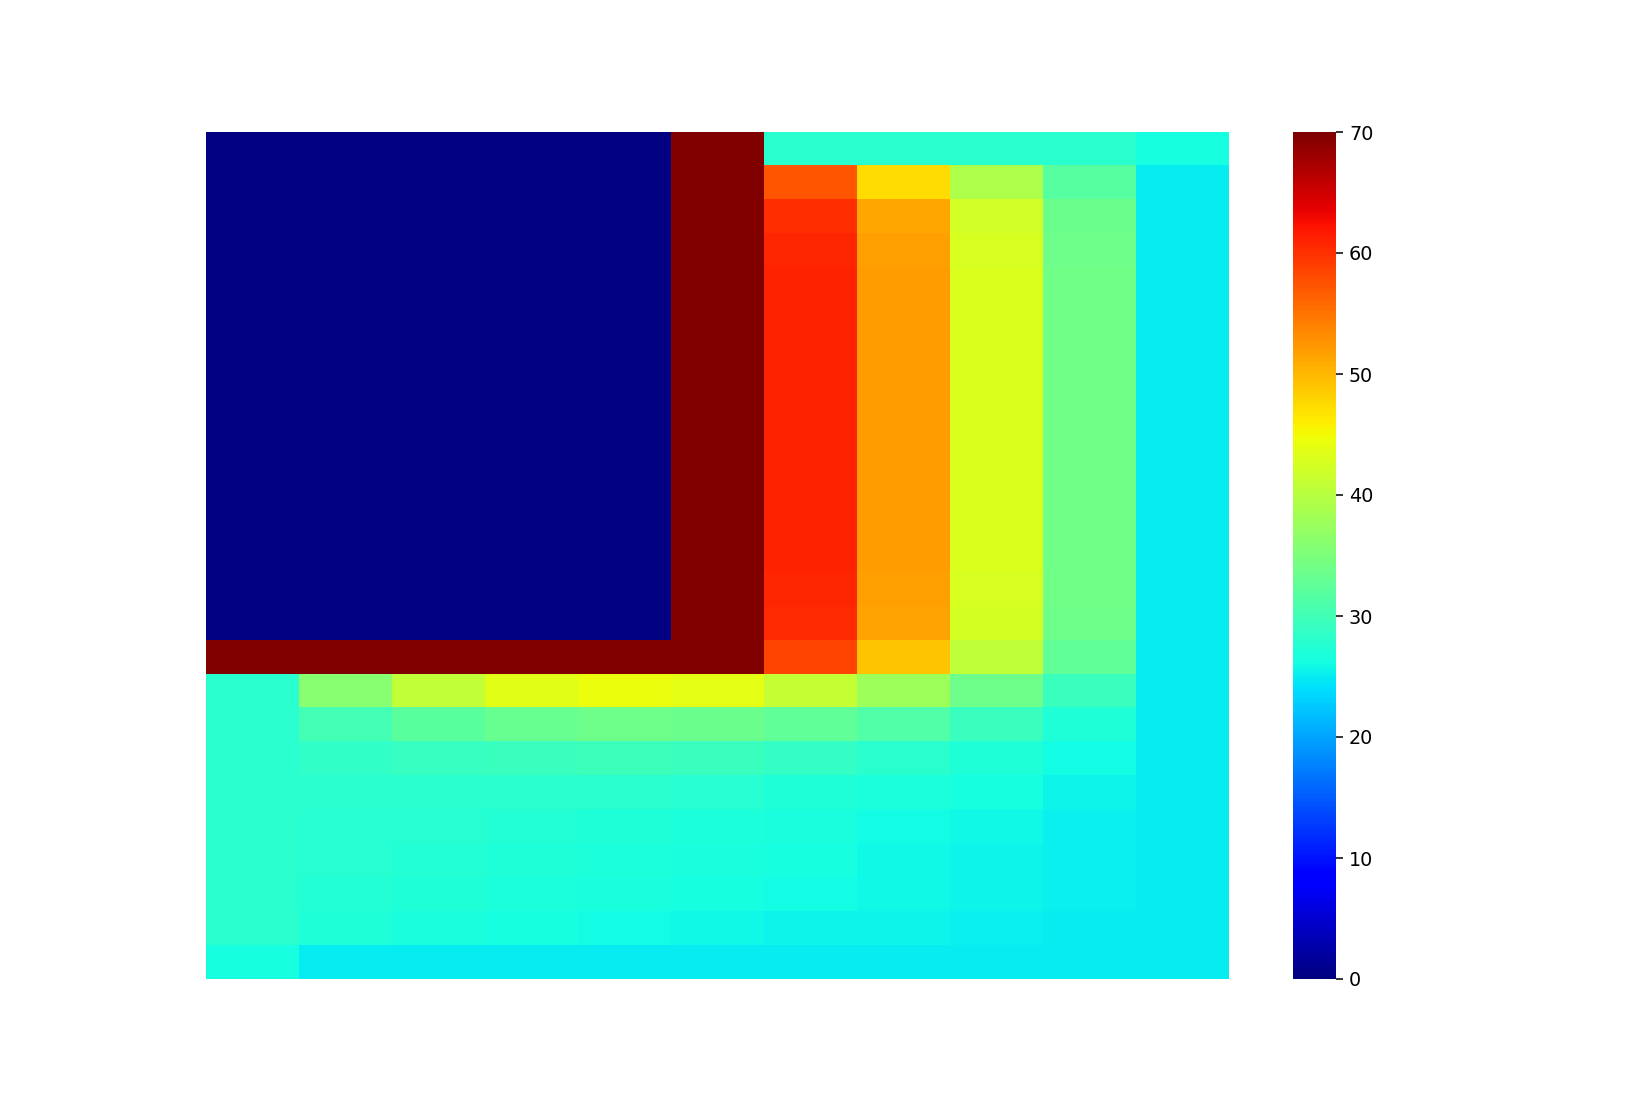

<AxesSubplot:>

In [64]:
plt.figure(figsize = (12, 8))
sns.heatmap(mtx, cmap = 'jet', xticklabels = False, yticklabels = False)

In [65]:
init = initial(h_1 = 1, h_2 = 5)
mtx = seidel(h_1 = 1, h_2 = 5)
print(mtx)

Количество итераций  828
[[ 0.          0.          0.         ... 28.         28.
  26.5       ]
 [ 0.          0.          0.         ... 27.77086413 27.5330844
  25.        ]
 [ 0.          0.          0.         ... 27.54884611 27.15798098
  25.        ]
 ...
 [28.         32.51250274 34.38154597 ... 25.14419707 25.07994166
  25.        ]
 [28.         28.75942278 29.67741611 ... 25.07189784 25.03981613
  25.        ]
 [26.5        25.         25.         ... 25.         25.
  25.        ]]


<IPython.core.display.Javascript object>


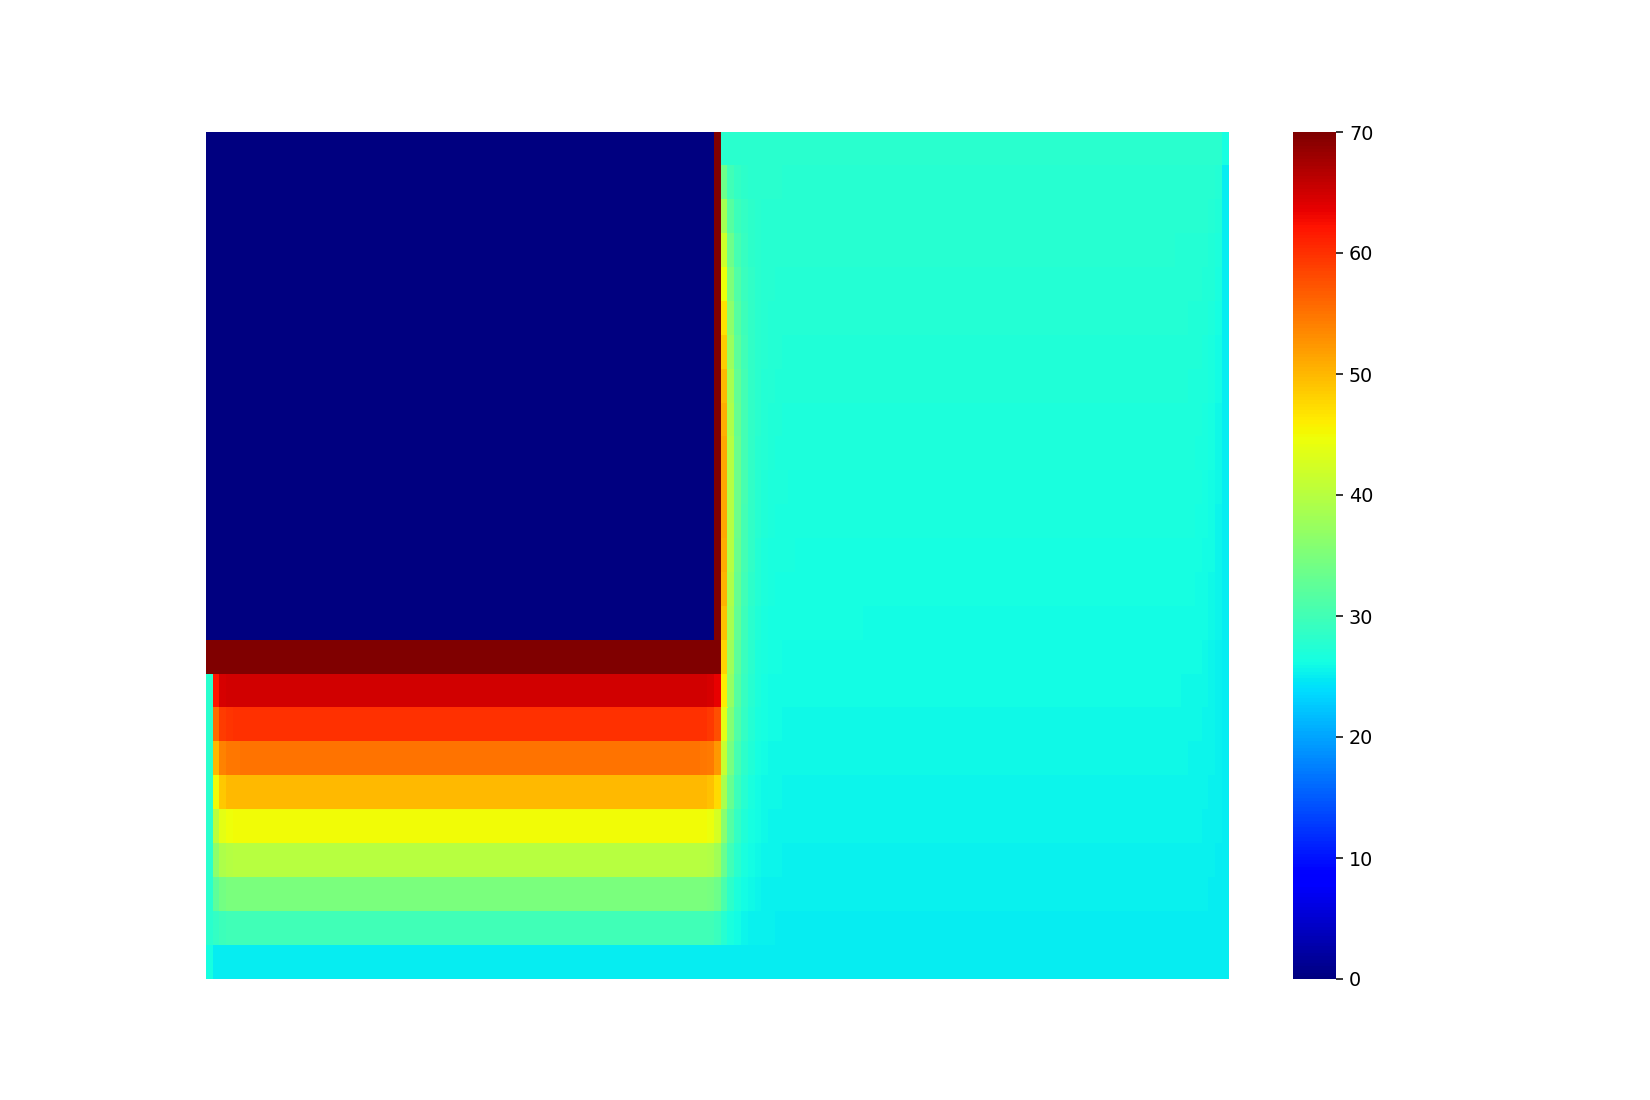

<AxesSubplot:>

In [66]:
plt.figure(figsize = (12, 8))
sns.heatmap(mtx, cmap = 'jet', xticklabels = False, yticklabels = False)

In [67]:
init = initial(h_1 = 5, h_2 = 1)
mtx = seidel(h_1 = 5, h_2 = 1)
print(mtx)

Количество итераций  1316
[[ 0.          0.          0.         ... 28.         28.
  26.5       ]
 [ 0.          0.          0.         ... 28.61226422 26.84117978
  25.        ]
 [ 0.          0.          0.         ... 29.87989309 27.43474287
  25.        ]
 ...
 [28.         27.78026723 27.56767578 ... 25.09652055 25.04815967
  25.        ]
 [28.         27.53795328 27.16773214 ... 25.05163371 25.02575005
  25.        ]
 [26.5        25.         25.         ... 25.         25.
  25.        ]]


<IPython.core.display.Javascript object>


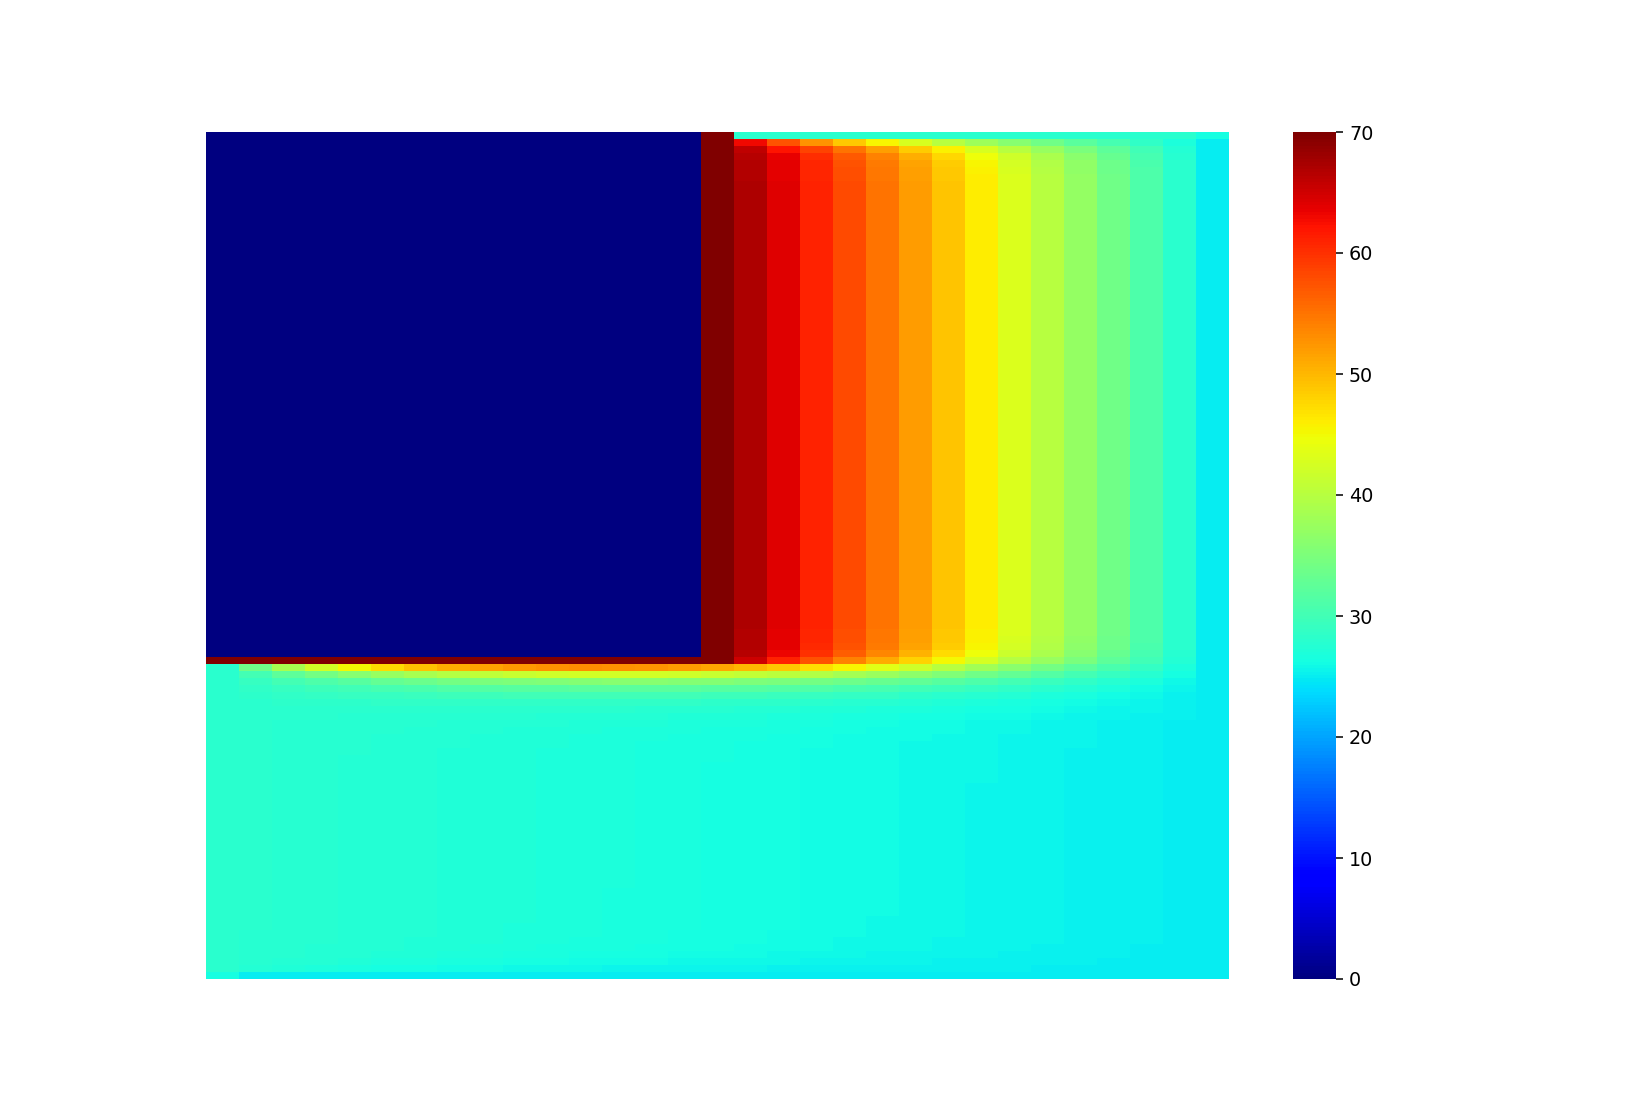

<AxesSubplot:>

In [68]:
plt.figure(figsize = (12, 8))
sns.heatmap(mtx, cmap = 'jet', xticklabels = False, yticklabels = False)

<IPython.core.display.Javascript object>


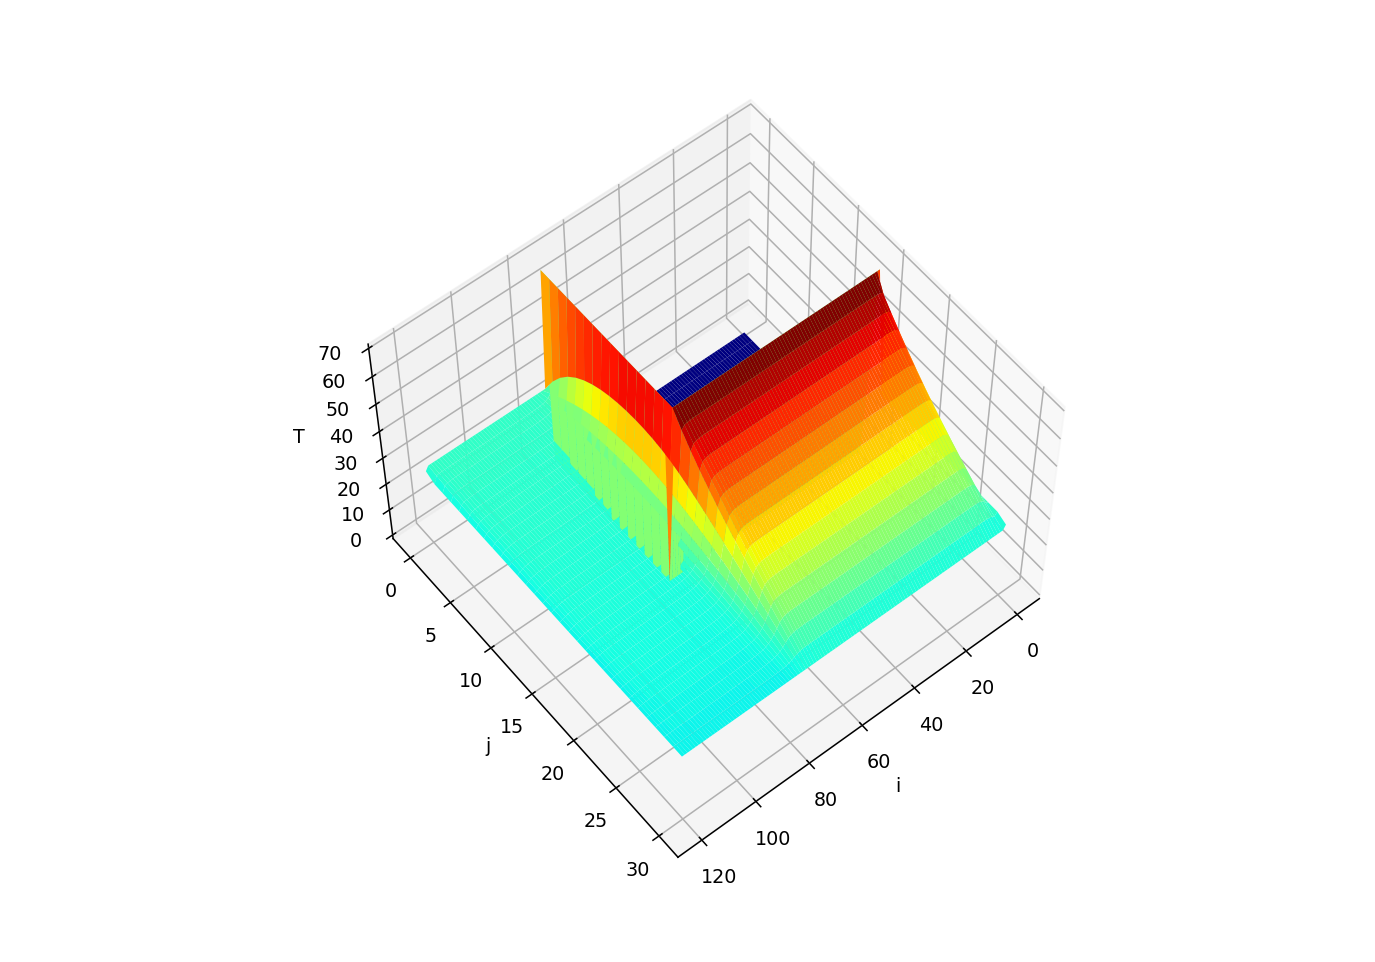

In [69]:
fig = plt.figure(figsize=(10, 7))
ax_3d = fig.add_subplot(projection='3d')

x = np.arange(0, init.shape[0])
y = np.arange(0, init.shape[1])

x, y = np.meshgrid(x, y)

ax_3d.plot_surface(x, y, f(x, y), rstride = 1, cstride = 1, cmap = 'jet', color = 'y')

ax_3d.set_xlabel('i')
ax_3d.set_ylabel('j')
ax_3d.set_zlabel('T')

plt.show()

In [26]:
def g(x, y):
    return np.abs(mtx[x, y] - mtx2[x, y]) / 3

<IPython.core.display.Javascript object>


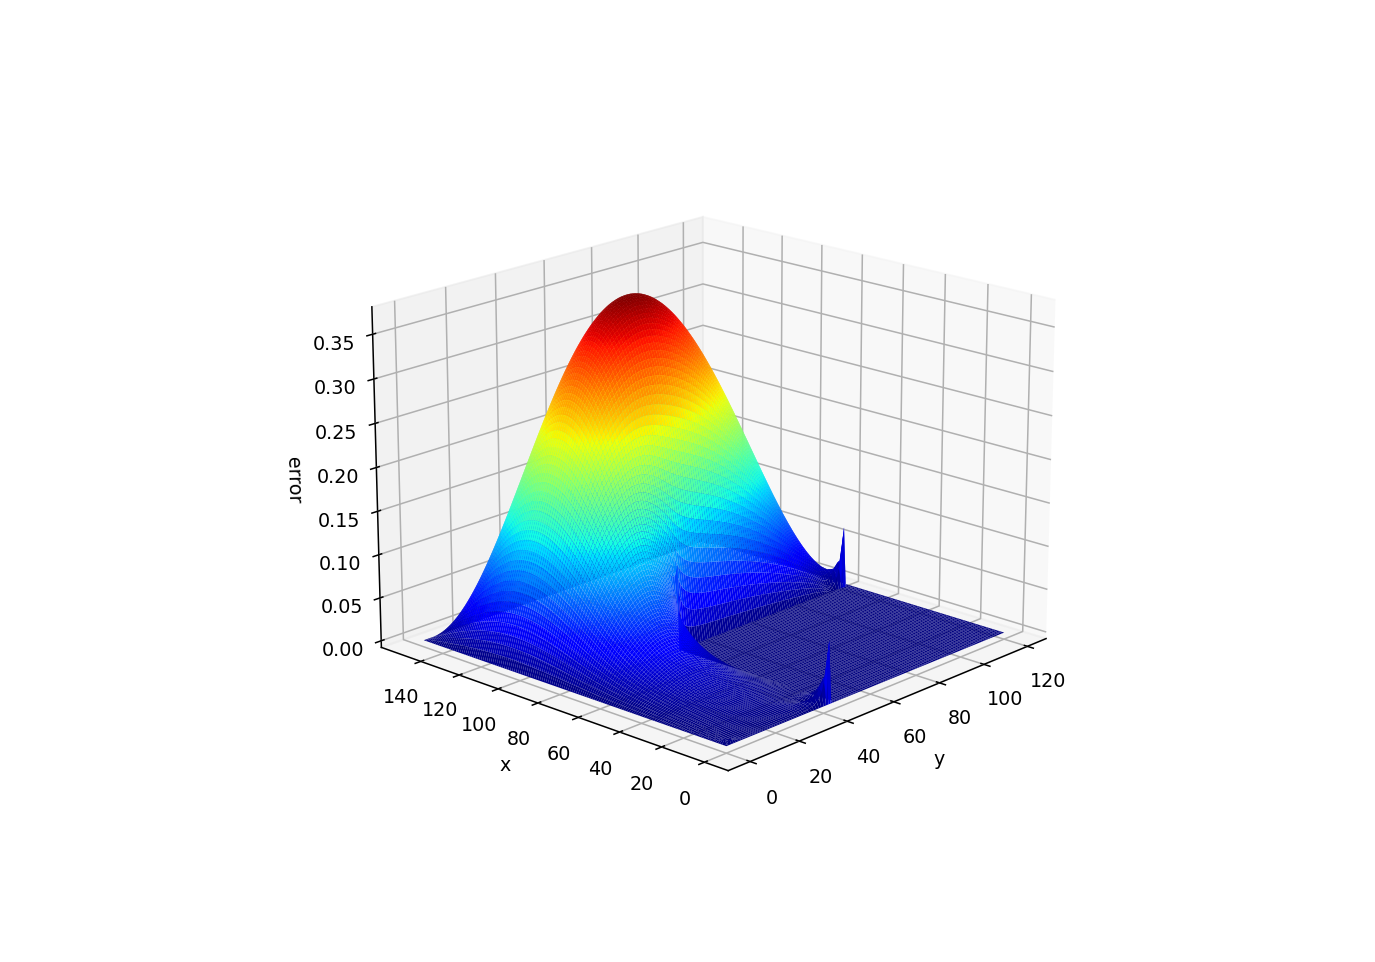

In [28]:
fig = plt.figure(figsize=(10, 7))
ax_3d = fig.add_subplot(projection='3d')

x = np.arange(0, mtx.shape[0])
y = np.arange(0, mtx.shape[1])

x, y = np.meshgrid(x, y)

ax_3d.plot_surface(np.flip(x), y, g(x, y), rstride = 1, cstride = 1, cmap = 'jet', color = 'y')

ax_3d.set_xlabel('y')
ax_3d.set_ylabel('x')
ax_3d.set_zlabel('error')

plt.show()